## 1.数据预处理阶段

In [16]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import pandas as pd
fi_id_nfi_dict_path = "./data/fi_nfi_id.pkl"
feature_id_time_spatial_path = "./data/feature_id_time_spatial.pkl"
Best_label_cluster_path = "./processing/Best_label_cluster.pkl"
BDP_val_prediction_path = "./data/BDP_val_prediction.pkl"

fi_id_nfi_dict = np.load(fi_id_nfi_dict_path, allow_pickle=True)
Best_label_cluster  = np.load(Best_label_cluster_path, allow_pickle=True)
feature_id_time_spatial = np.load(feature_id_time_spatial_path, allow_pickle=True)
BDP_val_prediction = np.load(BDP_val_prediction_path, allow_pickle=True)
# print(Best_label_cluster)
# print(BDP_val_prediction)
# print(feature_id_time_spatial)
# print(fi_id_nfi_dict)



### 1.1统计positive&negative在各个簇的占比

In [17]:
p_n_ratio = {}
pos = []
pos_pro = []
neg = []
neg_pro = []

for id_cluster, fid_list in Best_label_cluster.items():
    labels_n_p = [0]*2
    for f_id in fid_list:
        label = BDP_val_prediction[f_id]['ground truth']
        labels_n_p[label] += 1
    p_n_ratio[id_cluster] = labels_n_p
for id_cluster, l_n_p in p_n_ratio.items():
    a = l_n_p[0]/(l_n_p[0]+l_n_p[1])
    b = l_n_p[1]/(l_n_p[0]+l_n_p[1])
    neg.append(l_n_p[0])
    pos.append(l_n_p[1])
    neg_pro.append(a)
    pos_pro.append(b)    
    print("id_cluster:{} negative:{}/{}, positive:{}/{}".format(id_cluster, l_n_p[0], a, l_n_p[1], b))
id_clusters = list(p_n_ratio.keys())
result = { "Cluster ID": id_clusters, "Number of negative":neg, "Proportion of negative": neg_pro,
          "Number of positive":pos, "Proportion of positive":pos_pro
}
data = pd.DataFrame(result, index=None)
data.to_csv("./pdf/Cluster_info.csv")

id_cluster:5 negative:467/0.8616236162361623, positive:75/0.13837638376383765
id_cluster:8 negative:528/0.4835164835164835, positive:564/0.5164835164835165
id_cluster:3 negative:435/0.8085501858736059, positive:103/0.19144981412639406
id_cluster:0 negative:530/0.8128834355828221, positive:122/0.18711656441717792
id_cluster:6 negative:278/0.8475609756097561, positive:50/0.1524390243902439
id_cluster:4 negative:313/0.8575342465753425, positive:52/0.14246575342465753
id_cluster:1 negative:361/0.7969094922737306, positive:92/0.20309050772626933
id_cluster:7 negative:81/0.75, positive:27/0.25
id_cluster:2 negative:127/0.8698630136986302, positive:19/0.13013698630136986


## 2.频谱图的构建

In [4]:

def spectrogram_draw(data):
    duration_time = 2
    x = np.arange(0, duration_time, 0.01)
    plt.plot(x, data)
    plt.xlabel("Time [sec]")
    plt.ylabel("Voltage [v]")
    NFFT = 200
    Fs = 100
    plt.show()
    Pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT, Fs=Fs, noverlap=0)
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")
    plt.show()

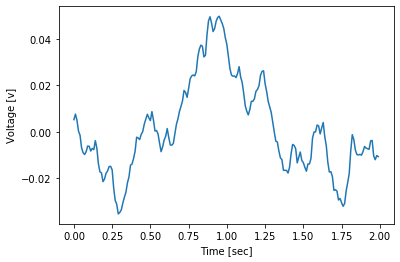

/home/cbd109-3/applications/anaconda3/envs/ching/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=200).
  # Remove the CWD from sys.path while we load stuff.


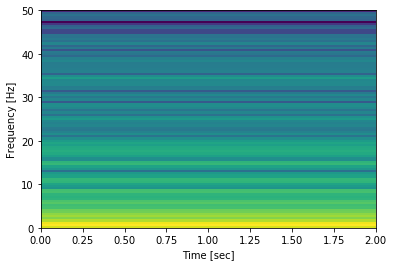

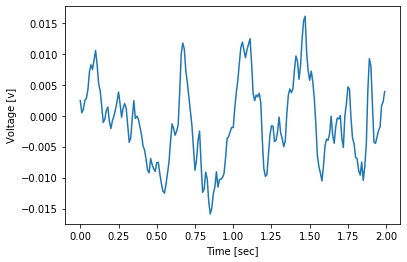

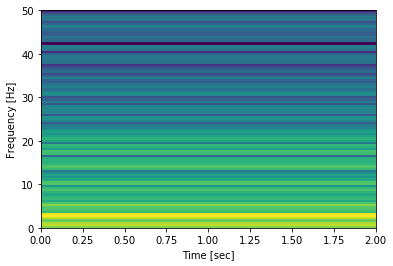

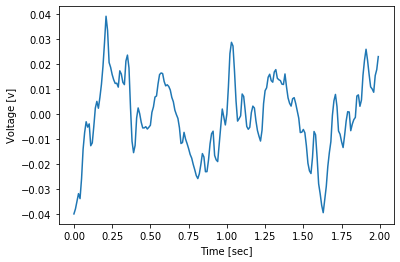

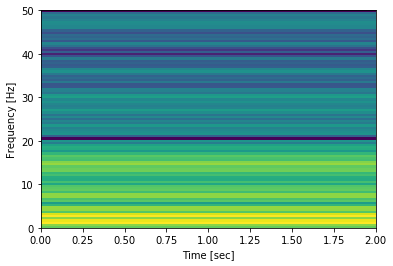

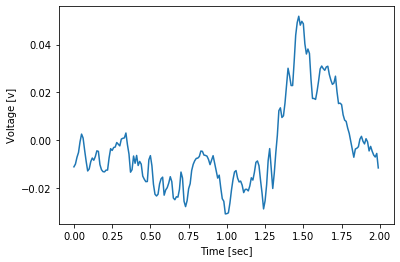

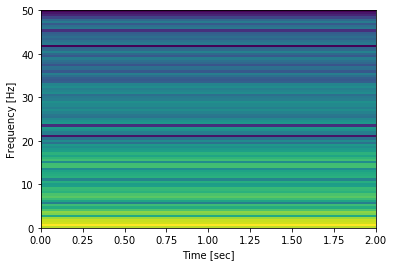

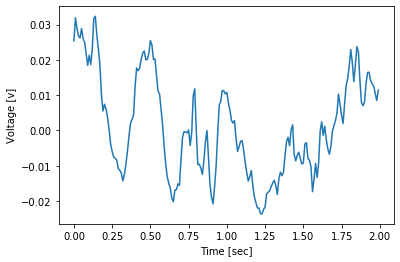

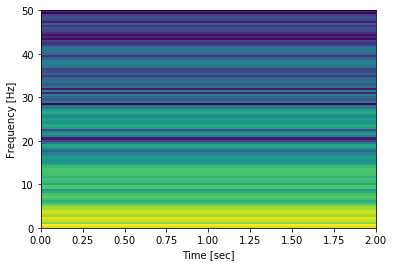

In [12]:
for cluster_id, fi_ids in Best_label_cluster.items():
    data_y = np.zeros(200)
    for fi_id in fi_ids:
        # print(fi_id)
        # raw_data_path = fi_id_nfi_dict
        raw_data_nfi = np.load(fi_id_nfi_dict[fi_id]['nfi_path'], allow_pickle=True)
        channel_spot = feature_id_time_spatial[fi_id]["spatial"]
        channel_data = raw_data_nfi[channel_spot]
        data_y += channel_data
    # print(data_y)
    spectrogram_draw(data_y)
    
    
    
    

### 2.1 频谱图功能测试

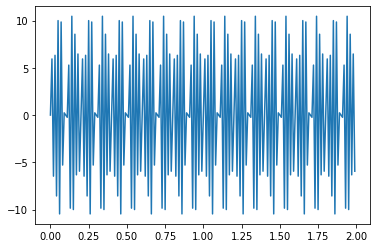

/home/cbd109-3/applications/anaconda3/envs/ching/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=200).
  if __name__ == '__main__':


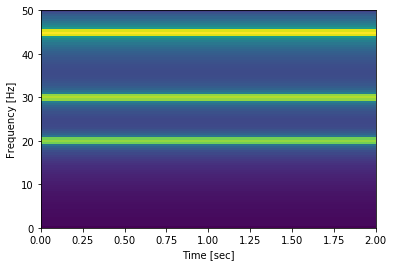

200


In [13]:
def specgram_draw(data):
    duration_time = 2
    dt = 0.01
    x = np.arange(0.0, duration_time, dt)
    plt.plot(x, data)
    NFFT = 200
    Fs = 100
    plt.show()
    Pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT, Fs=Fs, noverlap=0)
    # The `specgram` method returns 4 objects. They are:
    # - Pxx: the periodogram
    # - freqs: the frequency vector
    # - bins: the centers of the time bins
    # - im: the matplotlib.image.AxesImage instance representing the data in the plot
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")
    plt.show()
t = np.arange(0, 2, 0.01)
s1 = np.sin(2 * np.pi * 20 * t)
s2 = 2 * np.sin(2 * np.pi * 30 * t)
y  = s1+s2+10 * np.sin(2 * np.pi * 45 * t)
specgram_draw(y)
print(len(y))

## 3.相似度较高的数据展示

In [5]:
from dtw import dtw
from tqdm.notebook import tqdm as tqdm

def similarity_DTW(s1, s2):
    ratio = 50 # 设定的放缩系数，避免数据的相似度过于集中
    euclidean_norm = lambda x, y: np.abs(ratio * (x - y))
    d, cost_matrix, acc_cost_matrix, path = dtw(s1, s2, dist=euclidean_norm)
    score = 1 - np.tanh(d)  # 相似度的评分【0,1】 0： 完全不同， 1： 完全相同
    return score

def get_top_score_series(series_dict, dba_wave, top_n = 10):
    top_wave_cluster = {}
    for cluster_id, feature_data in tqdm(series_dict.items()):
        dba_w = dba_wave[cluster_id]
        cluster_score ={}
        for _d, _id in tqdm(feature_data):
            score = similarity_DTW(_d, dba_w)
            cluster_score[_id] = score
        cluster_result = sorted(cluster_score.items(), key=lambda x:-x[1])
        top_wave_cluster[cluster_id] = cluster_result[:top_n]
    return top_wave_cluster

In [6]:
wave_clusters_id_feature_data_path = "./processing/wave_clusters_id_feature_data.pkl"
DBA_wave_path = "./processing/DBA_wave.pkl"
wave_clusters_id_feature_data = np.load(wave_clusters_id_feature_data_path, allow_pickle=True)
DBA_wave = np.load(DBA_wave_path, allow_pickle=True)
top_wave_cluster = get_top_score_series(wave_clusters_id_feature_data, DBA_wave)

{2: [('a4e5e54c-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.87105529895394), ('a5c1d710-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8694880066784845), ('a4e5e306-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8680258254836343), ('a5770d5e-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8664556137388508), ('a4e5e51f-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8609519272774911), ('a4e5e355-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8575180322205345), ('a5e5eb12-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8570073175101318), ('a4e5e316-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8548642709609013), ('a52f387c-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8539654174009313), ('a5770ead-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8521906485760025)], 3: [('b12e666a-2555-11ea-9699-e0d55e6ff654-0.npy', 0.9571087326294127), ('a59dcfb8-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.955412677455394), ('a5771006-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.953536291581724), ('b12e6986-2555-11ea-9699-e0d55e6ff654-0.npy', 0.953162378032272), ('a5c1d5e2-fa3a-11e9-a8f2-e0d55e6ff654-2.np

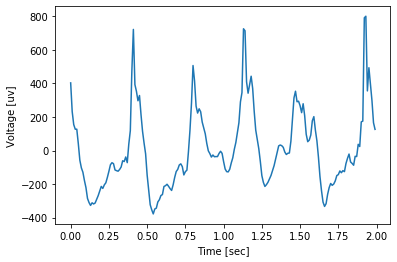

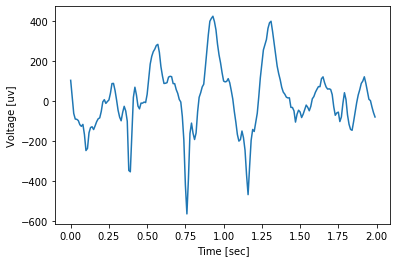

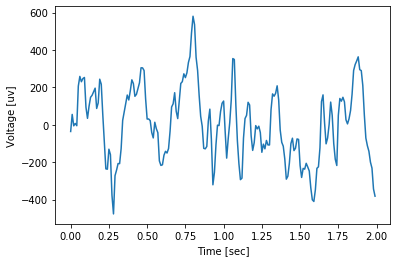

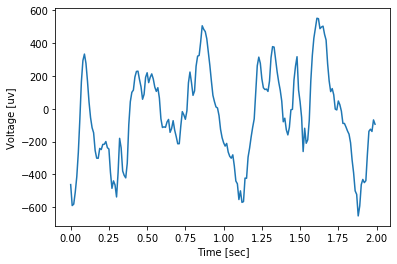

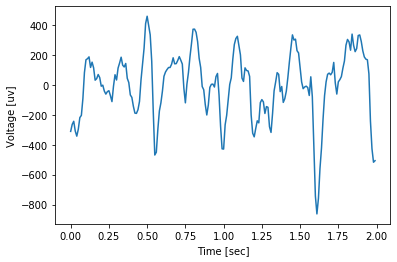

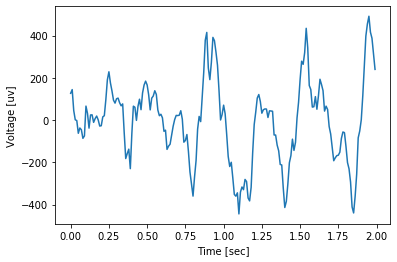

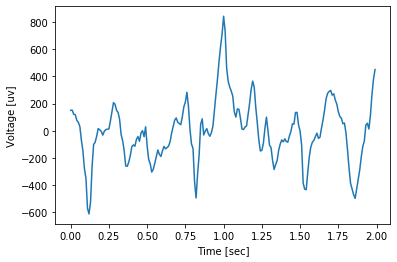

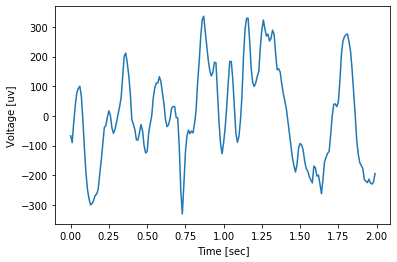

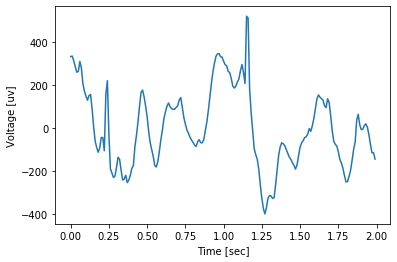

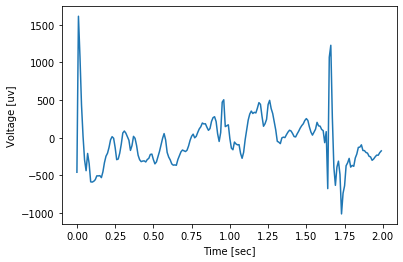

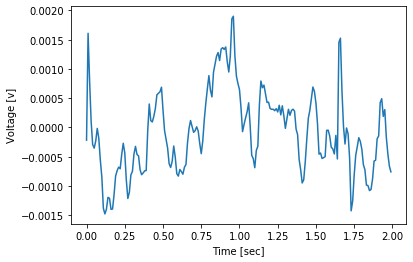

/home/cbd109-3/applications/anaconda3/envs/ching/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=200).
  # Remove the CWD from sys.path while we load stuff.


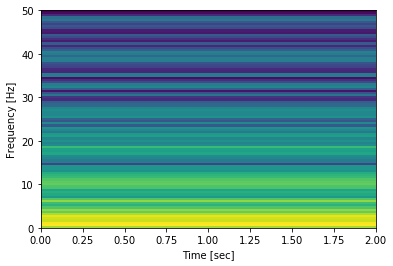

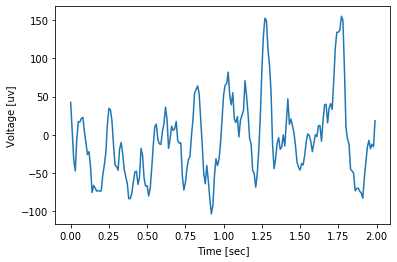

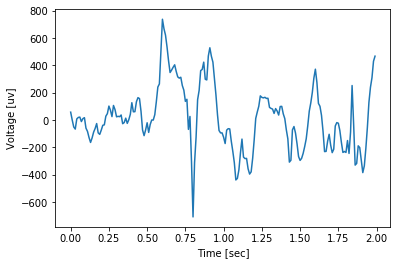

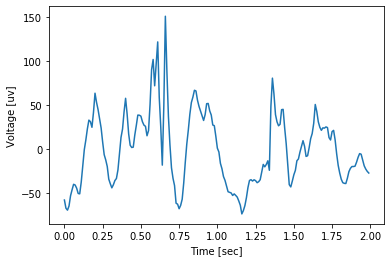

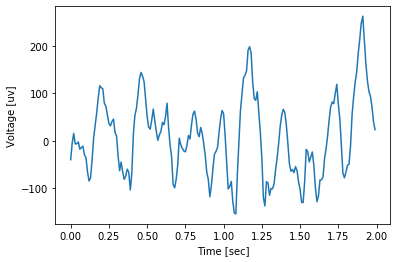

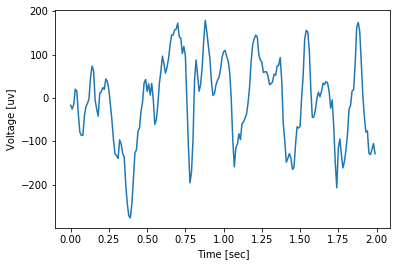

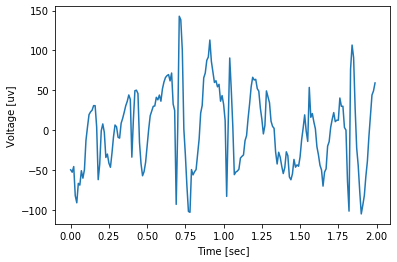

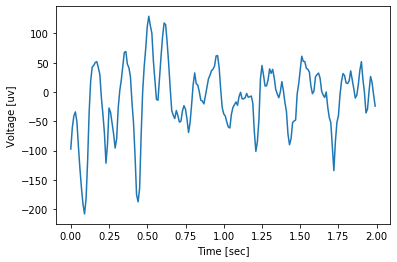

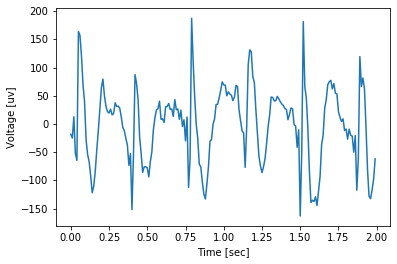

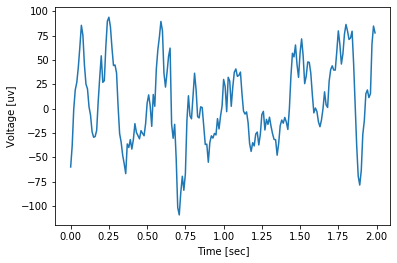

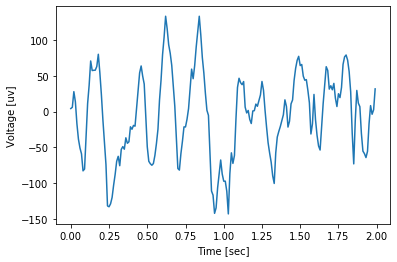

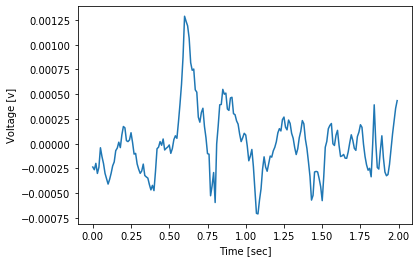

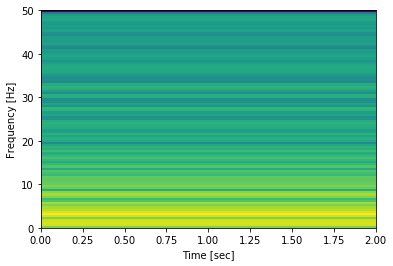

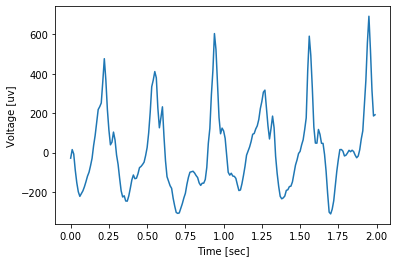

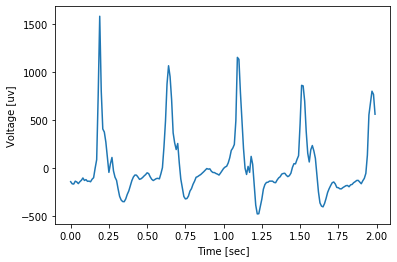

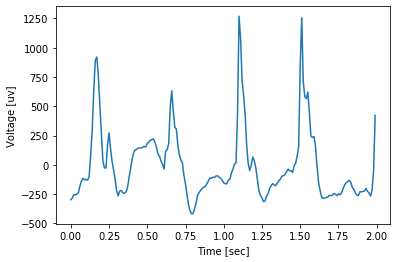

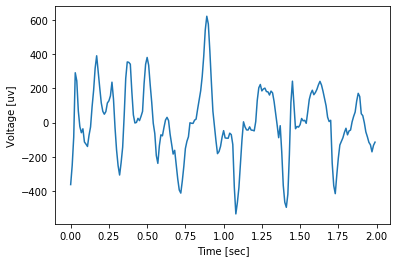

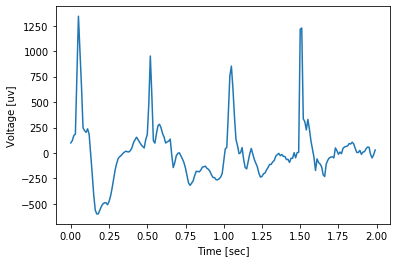

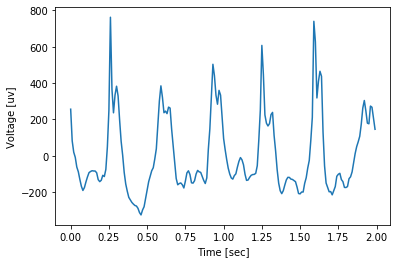

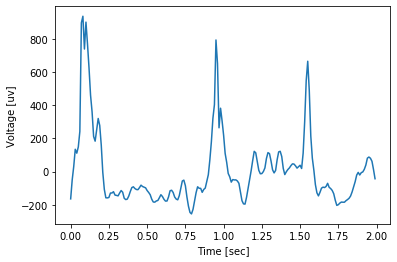

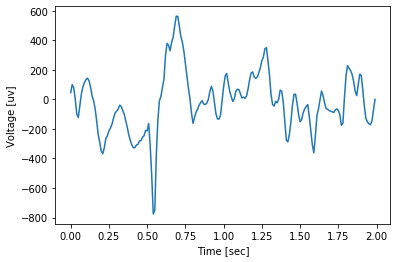

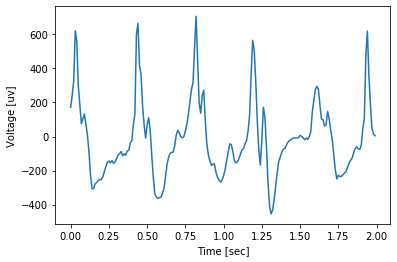

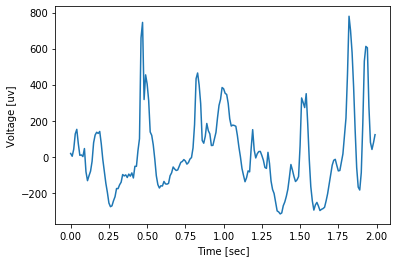

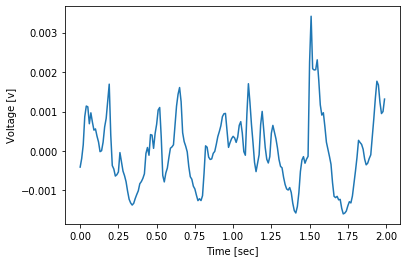

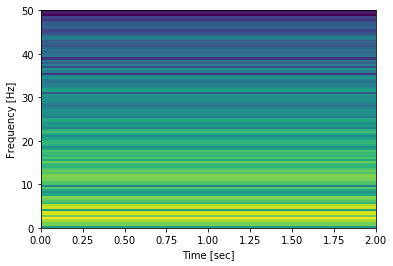

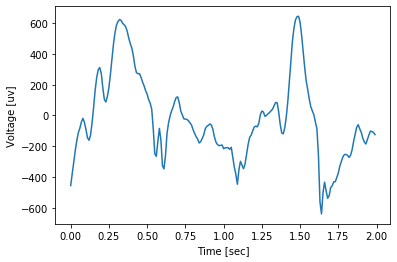

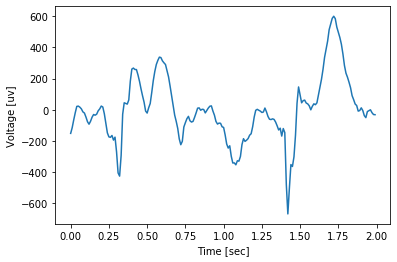

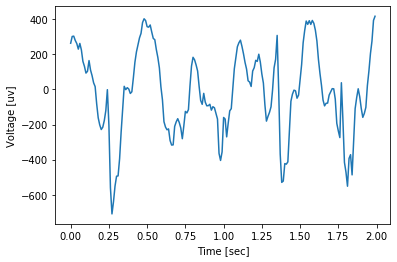

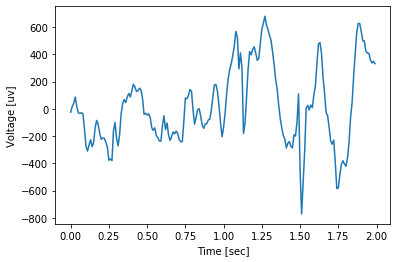

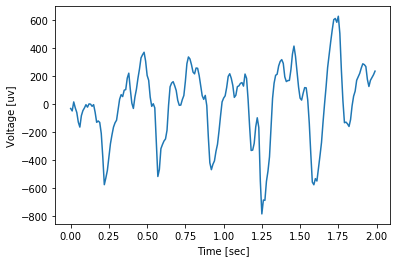

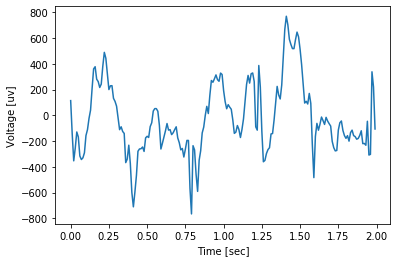

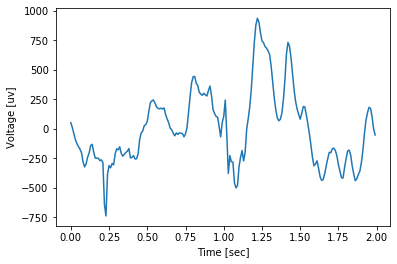

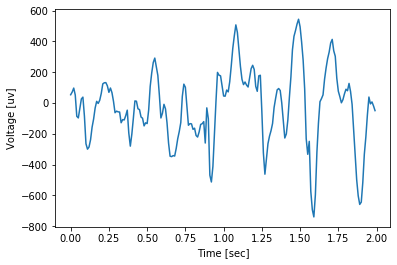

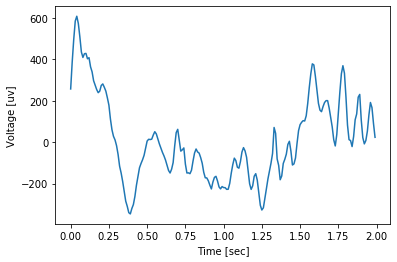

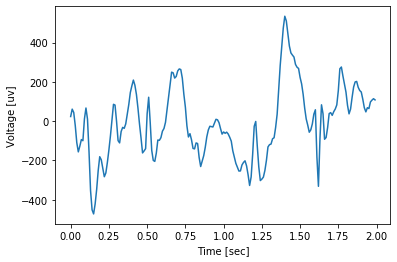

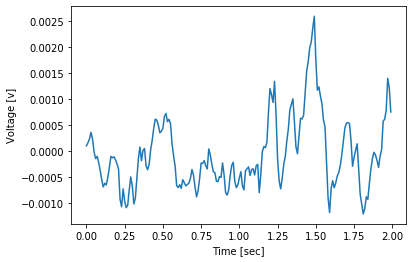

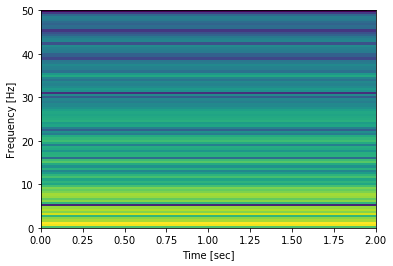

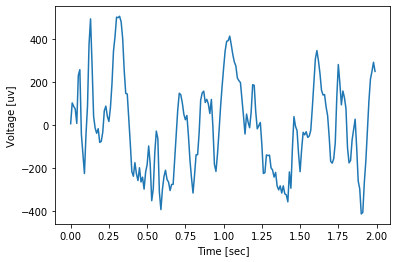

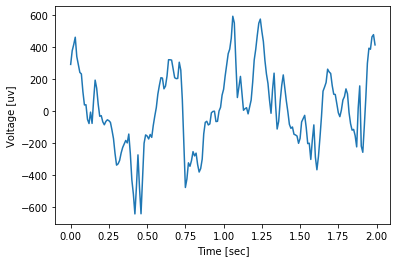

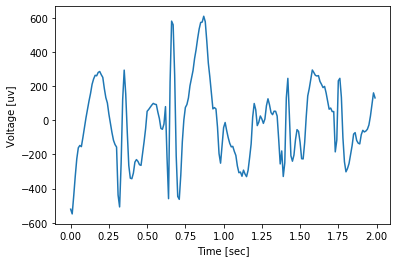

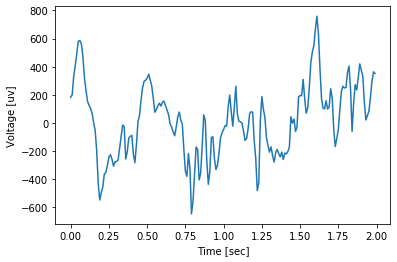

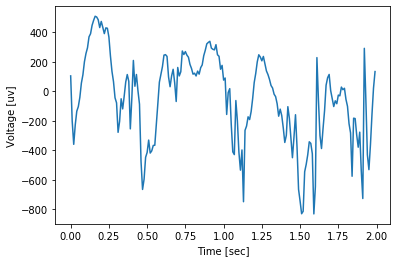

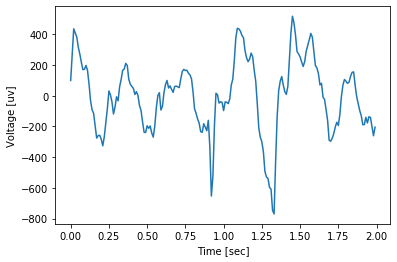

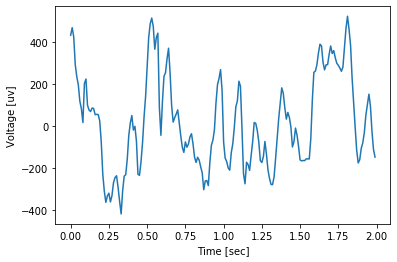

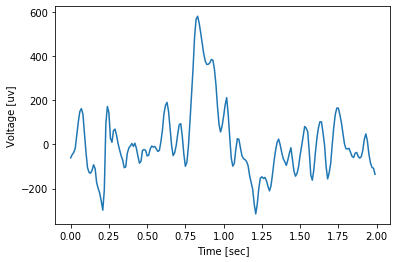

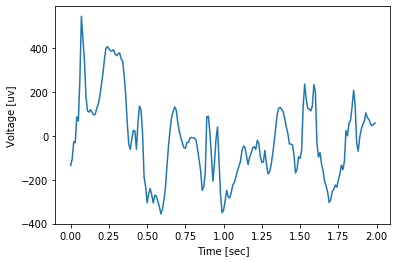

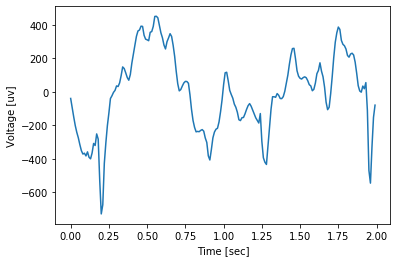

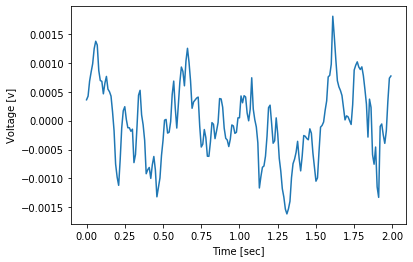

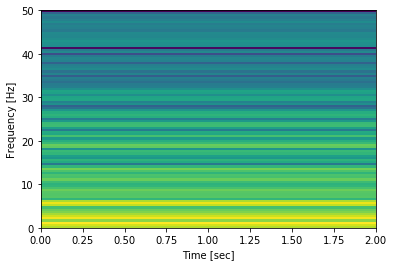

In [15]:
import os
def makedir(path):
    if os.path.exists(path) is not True:
        os.makedirs(path)
        print("文件创建成功！")
print(top_wave_cluster)
for cluster_id, feature_ids in top_wave_cluster.items():
    print("Cluster ID{}".format(cluster_id))
    # path_negative = "./result/{}".format(cluster_id)
    # path_positive = "./result/{}".format(cluster_id)
    # makedir(path_negative)
    # makedir(path_positive)
    y_spectrogram = np.zeros(200)
    for f_id, _ in feature_ids:
        raw_path = fi_id_nfi_dict[f_id]["nfi_path"]
        channel_no = feature_id_time_spatial[f_id]["spatial"]
        raw_data_channel = np.load(raw_path)[channel_no]
        x = np.arange(0, 2, 0.01)
        y_spectrogram += raw_data_channel
        plt.plot(x, raw_data_channel*1e6)
        plt.xlabel("Time [sec]")
        plt.ylabel("Voltage [uv]")
        plt.show()
    spectrogram_draw(y_spectrogram)
        

In [2]:
## 4.从cluster的数据中进行选择部分的feature的数据进行聚类

In [8]:
wave_cluster_id_feature_data_path = "./processing/wave_clusters_id_feature_data.pkl"
wave_cluster_id_feature_data = np.load(wave_cluster_id_feature_data_path, allow_pickle = True)
top_wave_cluster_heatmap = get_top_score_series(wave_cluster_id_feature_data, DBA_wave)
print(top_wave_cluster_heatmap)







{2: [('a4e5e54c-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.87105529895394), ('a5c1d710-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8694880066784845), ('a4e5e306-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8680258254836343), ('a5770d5e-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8664556137388508), ('a4e5e51f-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8609519272774911), ('a4e5e355-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8575180322205345), ('a5e5eb12-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8570073175101318), ('a4e5e316-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8548642709609013), ('a52f387c-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8539654174009313), ('a5770ead-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.8521906485760025)], 3: [('b12e666a-2555-11ea-9699-e0d55e6ff654-0.npy', 0.9571087326294127), ('a59dcfb8-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.955412677455394), ('a5771006-fa3a-11e9-a8f2-e0d55e6ff654-2.npy', 0.953536291581724), ('b12e6986-2555-11ea-9699-e0d55e6ff654-0.npy', 0.953162378032272), ('a5c1d5e2-fa3a-11e9-a8f2-e0d55e6ff65

In [12]:
save_path = "./processing/top_cluater_wave__fid_data.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(top_wave_cluster_heatmap, f)
    print("top cluster_id 写入成功")

TypeError: Required argument 'file' (pos 2) not found

TypeError: Required argument 'file' (pos 2) not found

top cluster_id 写入成功
top cluster_id 写入成功
